In [ ]:
# Step 1: Imports
import numpy as np
!pip install mne
import mne
import torch
import matplotlib.pyplot as plt
import torch.nn as nn


In [ ]:
# Step 2: Bandpass filter and convert raw EEG to MNE Raw object
def preprocess_with_mne(eeg_tensor, sfreq=128):
    eeg_np = eeg_tensor.numpy().astype(np.float32)
    if eeg_np.shape[0] > eeg_np.shape[1]:
        eeg_np = eeg_np.T

    ch_names = [f"EEG {i}" for i in range(eeg_np.shape[0])]
    ch_types = ["eeg"] * len(ch_names)
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
    raw = mne.io.RawArray(eeg_np, info, verbose=False)
    raw.filter(5, 45, fir_design='firwin', verbose=False)
    raw.set_eeg_reference('average', verbose=False)
    return raw

In [ ]:
# Step 3: Segment into 1s epochs and normalize
def segment_and_normalize(raw):
    epochs = mne.make_fixed_length_epochs(raw, duration=1.0, preload=True, verbose=False)
    data = epochs.get_data()  # shape: (n_epochs, n_channels, n_times)
    data = (data - data.mean(axis=2, keepdims=True)) / data.std(axis=2, keepdims=True)
    return data

# Step 4: Pad to 128 channels
def pad_channels_to_128(eeg_data):
    n_epochs, n_channels, n_times = eeg_data.shape
    if n_channels < 128:
        repeat_factor = int(np.ceil(128 / n_channels))
        padded = np.tile(eeg_data, (1, repeat_factor, 1))[:, :128, :]
    else:
        padded = eeg_data[:, :128, :]
    return padded

In [ ]:
def temporal_tokenize(eeg_data, token_size=4):
    n_epochs, n_channels, n_times = eeg_data.shape
    assert n_times % token_size == 0
    new_t = n_times // token_size
    tokenized = eeg_data.reshape(n_epochs, n_channels, new_t, token_size)
    tokenized = tokenized.transpose(0, 2, 1, 3).reshape(n_epochs, new_t, -1)  # (B, T, C*T_s)
    return tokenized

In [ ]:
class EEGEmbedder(nn.Module):
    def __init__(self, input_dim, embed_dim=1024):
        super().__init__()
        self.linear = nn.Linear(input_dim, embed_dim)

    def forward(self, x):  # x: (B, T, input_dim)
        return self.linear(x)

In [ ]:
# Step 8: Apply FFT manually
def apply_fft(eeg_data, sfreq=128):
    fft_vals = np.fft.rfft(eeg_data, axis=-1)  # (epochs, channels, freqs)
    power = np.abs(fft_vals) ** 2
    freqs = np.fft.rfftfreq(eeg_data.shape[-1], d=1/sfreq)
    return power, freqs


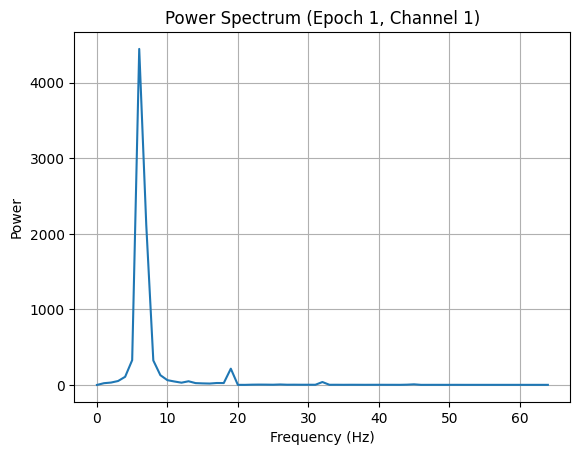

In [ ]:
power, freqs = apply_fft(padded)

# Power spectrum of 1st epoch, 1st channel
plt.plot(freqs, power[1,1])
plt.title("Power Spectrum (Epoch 1, Channel 1)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.grid(True)
plt.show()


In [ ]:
def plot_spectrogram(eeg_data, sfreq=128, channel_idx=0):
    signal = eeg_data[channel_idx]  # shape: (n_times,)
    plt.figure(figsize=(10, 4))
    plt.specgram(signal, NFFT=256, Fs=sfreq, noverlap=128, cmap='magma')
    plt.title("Spectrogram")
    plt.xlabel("Time [s]")
    plt.ylabel("Frequency [Hz]")
    plt.colorbar(label='Intensity [dB]')
    plt.tight_layout()
    plt.show()


In [ ]:
data_path= '/content/drive/MyDrive/eeg_signals_raw_with_mean_std.pth'
data_dict = torch.load(data_path)

In [ ]:
print(type(data_dict['dataset'][0]))
print(data_dict['dataset'][0])


In [ ]:
data= data_dict['dataset']
for sample in data:
    eeg_tensor = sample['eeg']
    raw = preprocess_with_mne(eeg_tensor)
    epochs = segment_and_normalize(raw)
    padded = pad_channels_to_128(epochs)
    tokens = temporal_tokenize(padded)

    embedder = EEGEmbedder(input_dim=tokens.shape[-1])
    embedded_tokens = embedder(torch.tensor(tokens).float())


<ipython-input-35-0db6c1c7eb7b>:4: UserWarning: Only one segment is calculated since parameter NFFT (=256) >= signal length (=128).
  plt.specgram(signal, NFFT=256, Fs=sfreq, noverlap=128, cmap='magma')


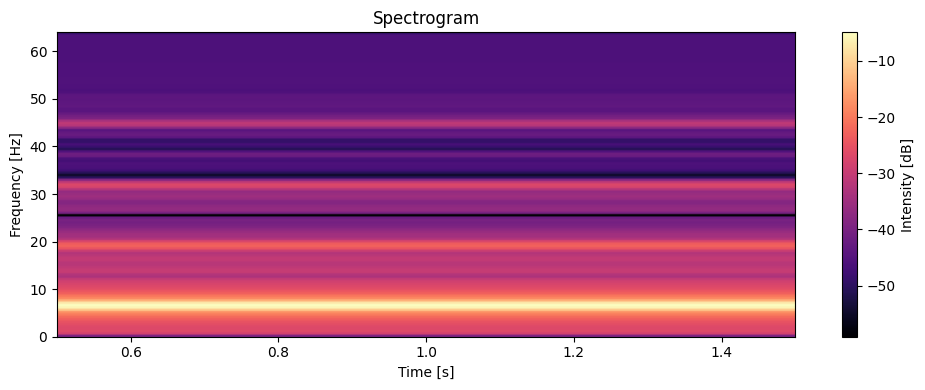

In [ ]:
plot_spectrogram(padded[0], channel_idx=0)


In [65]:
from scipy.fft import rfft, rfftfreq

def plot_fft_vs_time(eeg_data, sfreq=128, channel_idx=0):
    n_epochs = eeg_data.shape[0]
    time_axis = np.arange(n_epochs)  # 0.5-second epochs
    freq_values = []

    for epoch in eeg_data:
        signal = epoch[channel_idx]
        freqs = rfftfreq(len(signal), d=1/sfreq)
        fft_magnitude = np.abs(rfft(signal))
        weighted_mean_freq = np.sum(freqs * fft_magnitude) / np.sum(fft_magnitude)
        freq_values.append(weighted_mean_freq)

    plt.figure(figsize=(10, 4))
    plt.plot(time_axis, freq_values, marker='o')
    plt.title(f"Frequency vs Time")
    plt.xlabel("Time [s]")
    plt.ylabel("Frequency [Hz]" )
    plt.grid(True)
    plt.tight_layout()
    plt.show()


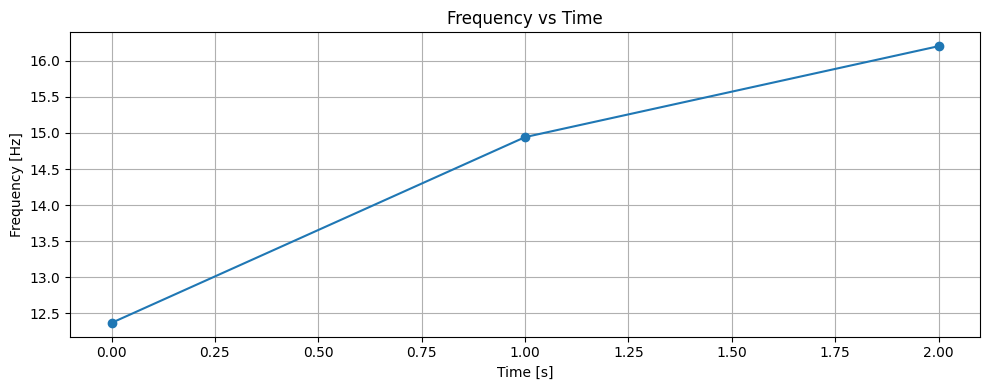

In [66]:

plot_fft_vs_time(padded)